In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import EMNIST
from torch.utils.data import DataLoader

import numpy as np
from tqdm import trange
from matplotlib import pyplot as plt

# Get cpu, gpu or mps device for training.
device = ("cuda" if torch.cuda.is_available()
          else "mps" if torch.backends.mps.is_available()
          else "cpu")
print(f"Using {device} device")

Using cuda device


In [3]:
def plot_results(train_losses, train_accs, test_losses, test_accs):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    xs = np.arange(1, len(train_losses) + 1, 1)
    axes[0].plot(xs, train_losses, label='Train')
    axes[0].plot(xs, test_losses, label='Test')
    axes[0].set_title('Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_xticks(xs)
    axes[1].plot(xs, train_accs, label='Train')
    axes[1].plot(xs, test_accs, label='Test')
    axes[1].set_title('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_xticks(xs)
    plt.tight_layout()
    plt.legend()
    plt.show()

In [4]:
def train_step(model, criterion, optimizer, dataloader, device=device):
    running_loss, correct = 0, 0
    # Move the model to training mode
    model.train()
    # Iterate over the dataloader
    for x, y in dataloader:
        # Move the datapoints to same device as the model
        x, y = x.to(device), y.to(device)
        # Clear the gradients
        optimizer.zero_grad()
        # Predict the output and perform the forward pass
        pred = model(x)
        # Compute prediction error
        loss = criterion(pred, y)
        # Backpropagation
        loss.backward()
        # Update the model weights
        optimizer.step()
        # Update the running loss
        running_loss += loss.item()
        # Update the correctly predicted counter
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    # Calculate and return the average loss and accuracy
    return running_loss / len(dataloader), 100 * correct / len(dataloader.dataset)


def test_step(model, criterion, dataloader, device=device):
    running_loss, correct = 0, 0
    # Move the model to training mode
    model.eval()
    # Disable gradient calculation
    with torch.no_grad():
      # Iterate over the dataloader
      for x, y in dataloader:
          # Move the datapoints to same device as the model
          x, y = x.to(device), y.to(device)
          # Predict the output and perform the forward pass
          pred = model(x)
          # Update the running loss
          running_loss += criterion(pred, y).item()
          # Update the correctly predicted counter
          correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    # Calculate and return the average accuracy
    return running_loss / len(dataloader), 100 * correct / len(dataloader.dataset)


def train_model(model, n_epochs, optimizer, train_loader, test_loader, device=device):
    criterion = nn.CrossEntropyLoss()
    train_losses, train_accs = [], []
    test_losses, test_accs = [], []
    for epoch in (pbar := trange(n_epochs)):
        # Train the model
        train_loss, train_acc = train_step(model, criterion, optimizer, train_loader, device)
        # Evaluate the model
        test_loss, test_acc = test_step(model, criterion, test_loader, device)
        # Display the results
        pbar.set_description(f'Train Loss = {train_loss:.3f} | Train Acc = {train_acc:.2f}% | Test Loss = {test_loss:.3f} | Test Acc = {test_acc:.2f}% ')
        # Store the results
        train_losses.append(train_loss), train_accs.append(train_acc), test_losses.append(test_loss), test_accs.append(test_acc)
    # Plot the results
    plot_results(train_losses, train_accs, test_losses, test_accs)
    return {'train_loss': train_losses, 'train_acc': train_accs, 'test_loss': test_losses, 'test_acc': test_accs}

In [5]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = EMNIST(root='./data', split='balanced', train=True, download=True, transform=transform)
test_dataset = EMNIST(root='./data', split='balanced', train=False, download=True, transform=transform)

print(f'Train dataset size: {len(train_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')

classes = train_dataset.classes
print(f'Classes:\n{classes}')

100%|██████████| 562M/562M [00:07<00:00, 71.2MB/s]


Train dataset size: 112800
Test dataset size: 18800
Classes:
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't']


In [6]:
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# Iterate over the data
for x, y in test_loader:
    print(f"Shape of X [N, C, H, W]: {x.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [6]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleNN, self).__init__()
        self.network = nn.Sequential(nn.Flatten(), nn.Linear(input_size, 128),
                                     nn.ReLU(), nn.Linear(128, 128),
                                     nn.ReLU(), nn.Linear(128, 64),
                                     nn.ReLU(), nn.Linear(64, num_classes))

    def forward(self, x):
        return self.network(x)

Train Loss = 1.156 | Train Acc = 66.71% | Test Loss = 1.170 | Test Acc = 66.59% : 100%|██████████| 30/30 [13:50<00:00, 27.67s/it]


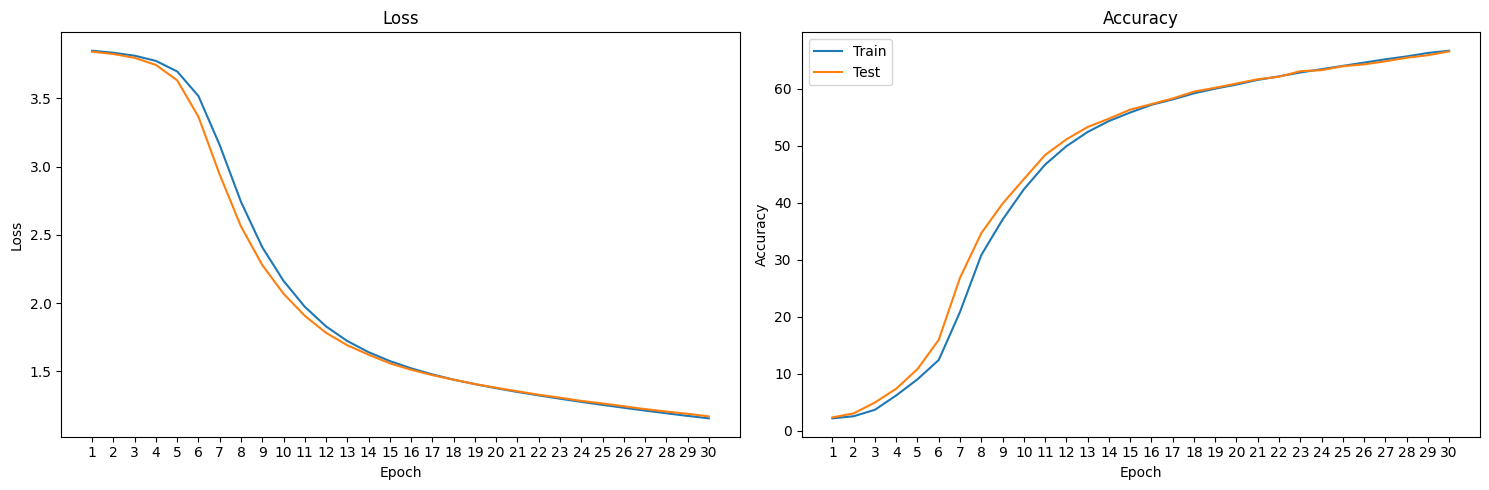

In [7]:
model = SimpleNN(input_size=28*28, num_classes=len(classes)).to(device)

optimizer = optim.SGD(model.parameters(), lr=0.001)

results = train_model(model, 30, optimizer, train_loader, test_loader)

Train Loss = 0.367 | Train Acc = 86.43% | Test Loss = 0.572 | Test Acc = 81.96% : 100%|██████████| 20/20 [09:13<00:00, 27.67s/it]


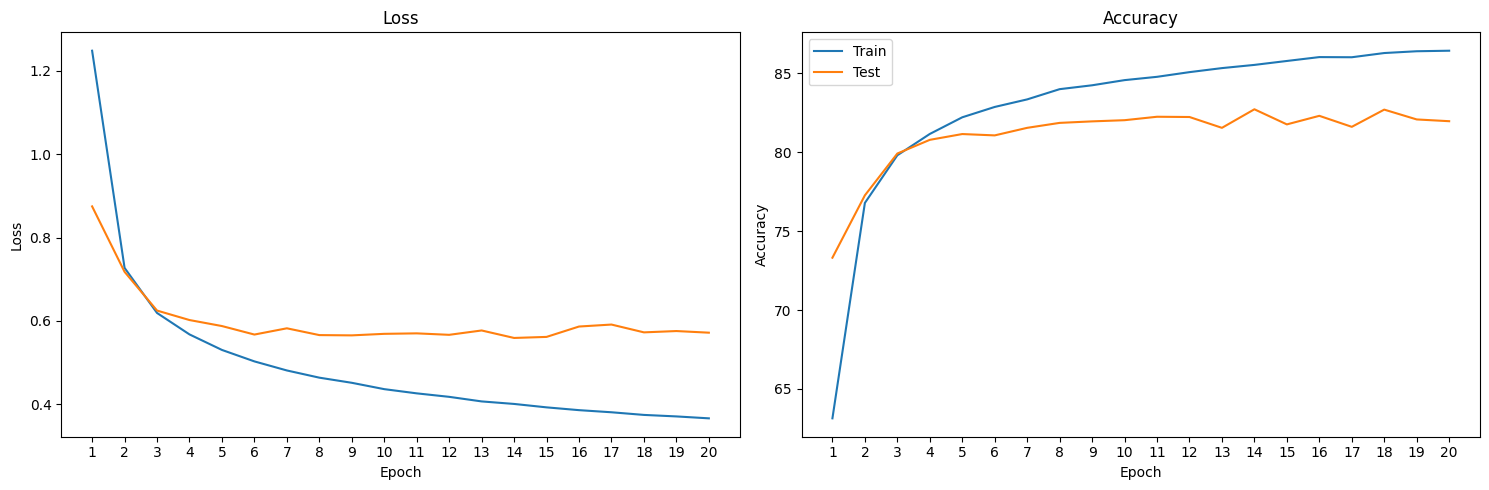

In [8]:
model = SimpleNN(input_size=28*28, num_classes=len(classes)).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

results = train_model(model, 20, optimizer, train_loader, test_loader)

In [9]:
class BiggerNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(BiggerNN, self).__init__()
        self.network = nn.Sequential(nn.Flatten(), nn.Linear(input_size, 512),
                                     nn.ReLU(), nn.Linear(512, 512),
                                     nn.ReLU(), nn.Linear(512, 512),
                                     nn.ReLU(), nn.Linear(512, 256),
                                     nn.ReLU(), nn.Linear(256, 256),
                                     nn.ReLU(), nn.Linear(256, 256),
                                     nn.ReLU(), nn.Linear(256, 128),
                                     nn.ReLU(), nn.Linear(128, 128),
                                     nn.ReLU(), nn.Linear(128, 128),
                                     nn.ReLU(), nn.Linear(128, 64),
                                     nn.ReLU(), nn.Linear(64, 64),
                                     nn.ReLU(), nn.Linear(64, 64),
                                     nn.ReLU(), nn.Linear(64, num_classes))

    def forward(self, x):
        return self.network(x)

Train Loss = 0.472 | Train Acc = 85.07% | Test Loss = 0.597 | Test Acc = 82.78% : 100%|██████████| 20/20 [10:26<00:00, 31.34s/it]


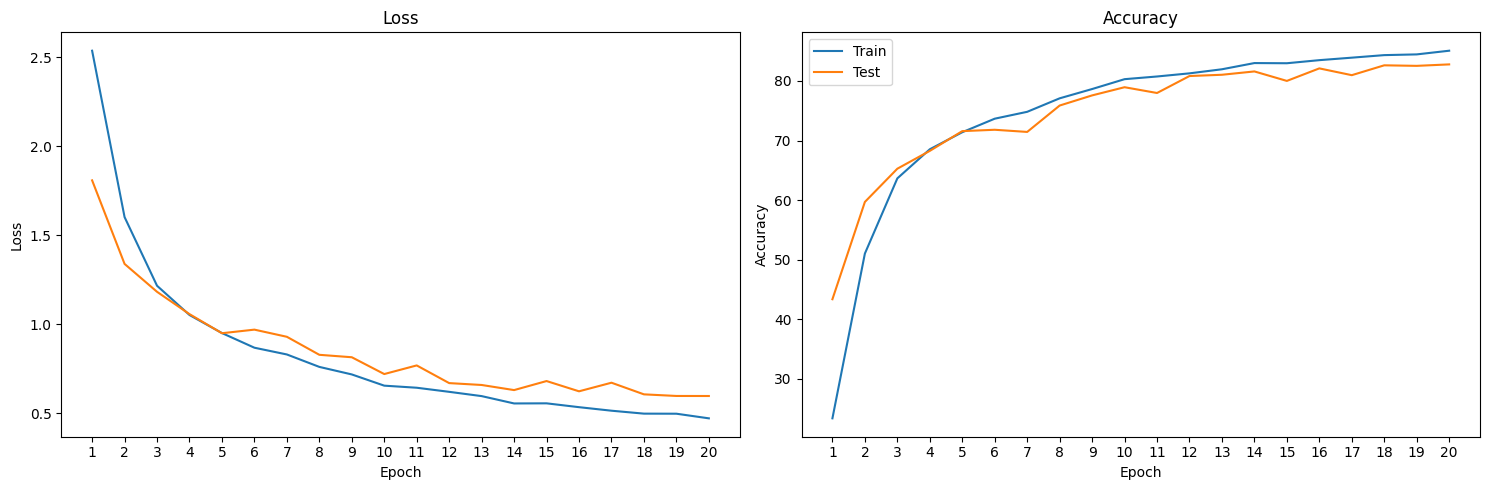

In [10]:
model = BiggerNN(input_size=28*28, num_classes=len(classes)).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

results = train_model(model, 20, optimizer, train_loader, test_loader)

In [11]:
class BiggerBN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(BiggerBN, self).__init__()
        self.network = nn.Sequential(nn.Flatten(), nn.Linear(28*28, 512), nn.BatchNorm1d(512),
                                     nn.ReLU(), nn.Linear(512, 512), nn.BatchNorm1d(512),
                                     nn.ReLU(), nn.Linear(512, 512), nn.BatchNorm1d(512),
                                     nn.ReLU(), nn.Linear(512, 256), nn.BatchNorm1d(256),
                                     nn.ReLU(), nn.Linear(256, 256), nn.BatchNorm1d(256),
                                     nn.ReLU(), nn.Linear(256, 256), nn.BatchNorm1d(256),
                                     nn.ReLU(), nn.Linear(256, 128), nn.BatchNorm1d(128),
                                     nn.ReLU(), nn.Linear(128, 128), nn.BatchNorm1d(128),
                                     nn.ReLU(), nn.Linear(128, 128), nn.BatchNorm1d(128),
                                     nn.ReLU(), nn.Linear(128, 128), nn.BatchNorm1d(128),
                                     nn.ReLU(), nn.Linear(128, 64), nn.BatchNorm1d(64),
                                     nn.ReLU(), nn.Linear(64, 64), nn.BatchNorm1d(64),
                                     nn.ReLU(), nn.Linear(64, 64), nn.BatchNorm1d(64),
                                     nn.ReLU(), nn.Linear(64, num_classes))

    def forward(self, x):
        return self.network(x)

Train Loss = 0.271 | Train Acc = 89.84% | Test Loss = 0.414 | Test Acc = 86.42% : 100%|██████████| 20/20 [11:49<00:00, 35.46s/it]


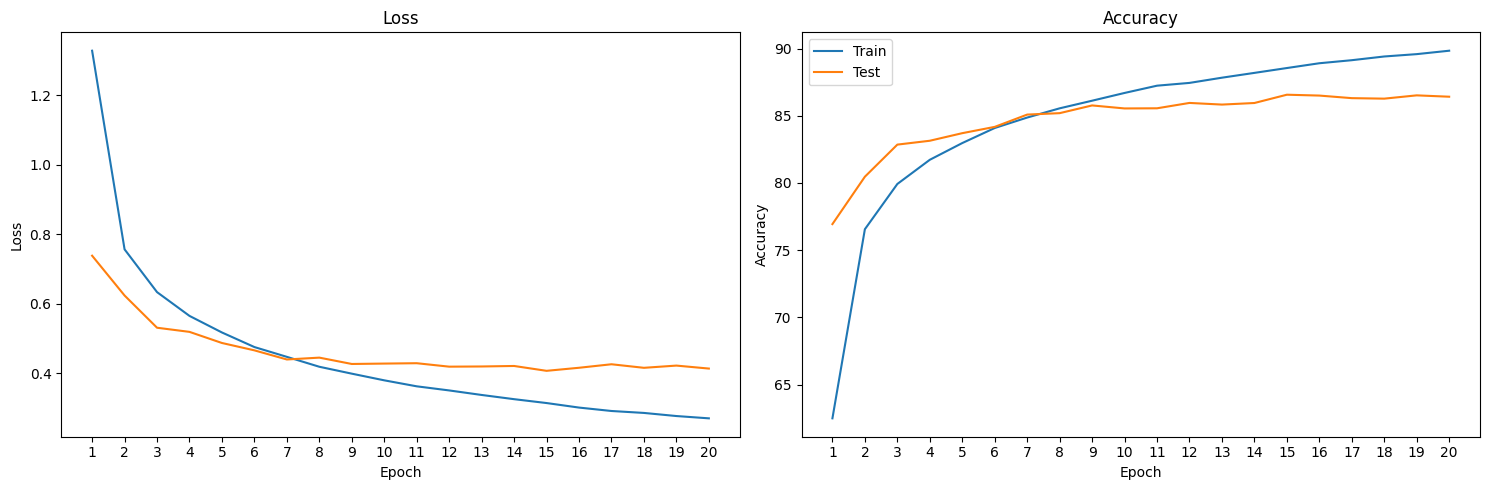

In [12]:
model = BiggerBN(input_size=28*28, num_classes=len(classes)).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

results = train_model(model, 20, optimizer, train_loader, test_loader)

In [13]:
class BiggerDO(nn.Module):
    def __init__(self, input_size, num_classes):
        super(BiggerDO, self).__init__()
        self.network = nn.Sequential(
            nn.Flatten(), nn.Linear(28*28, 512), nn.BatchNorm1d(512),
            nn.ReLU(), nn.Dropout(0.20), nn.Linear(512, 512), nn.BatchNorm1d(512),
            nn.ReLU(), nn.Dropout(0.20), nn.Linear(512, 512), nn.BatchNorm1d(512),
            nn.ReLU(), nn.Dropout(0.20), nn.Linear(512, 256), nn.BatchNorm1d(256),
            nn.ReLU(), nn.Dropout(0.15), nn.Linear(256, 256), nn.BatchNorm1d(256),
            nn.ReLU(), nn.Dropout(0.15), nn.Linear(256, 256), nn.BatchNorm1d(256),
            nn.ReLU(), nn.Dropout(0.15), nn.Linear(256, 128), nn.BatchNorm1d(128),
            nn.ReLU(), nn.Dropout(0.10), nn.Linear(128, 128), nn.BatchNorm1d(128),
            nn.ReLU(), nn.Dropout(0.10), nn.Linear(128, 128), nn.BatchNorm1d(128),
            nn.ReLU(), nn.Dropout(0.10), nn.Linear(128, 64), nn.BatchNorm1d(64),
            nn.ReLU(), nn.Dropout(0.05), nn.Linear(64, 64), nn.BatchNorm1d(64),
            nn.ReLU(), nn.Dropout(0.05), nn.Linear(64, 64), nn.BatchNorm1d(64),
            nn.ReLU(), nn.Dropout(0.05), nn.Linear(64, num_classes))

    def forward(self, x):
        return self.network(x)

Train Loss = 0.481 | Train Acc = 84.41% | Test Loss = 0.410 | Test Acc = 86.31% : 100%|██████████| 20/20 [12:07<00:00, 36.38s/it]


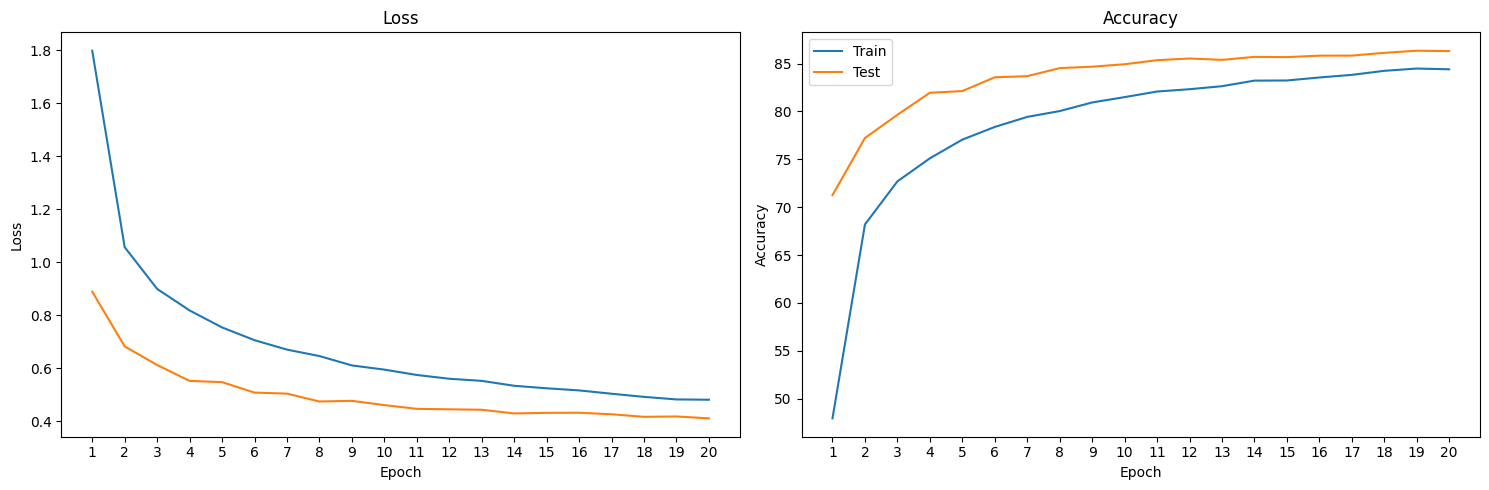

In [14]:
model = BiggerDO(input_size=28*28, num_classes=len(classes)).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

results = train_model(model, 20, optimizer, train_loader, test_loader)

Train Loss = 0.372 | Train Acc = 87.34% | Test Loss = 0.381 | Test Acc = 87.37% : 100%|██████████| 10/10 [06:01<00:00, 36.19s/it]


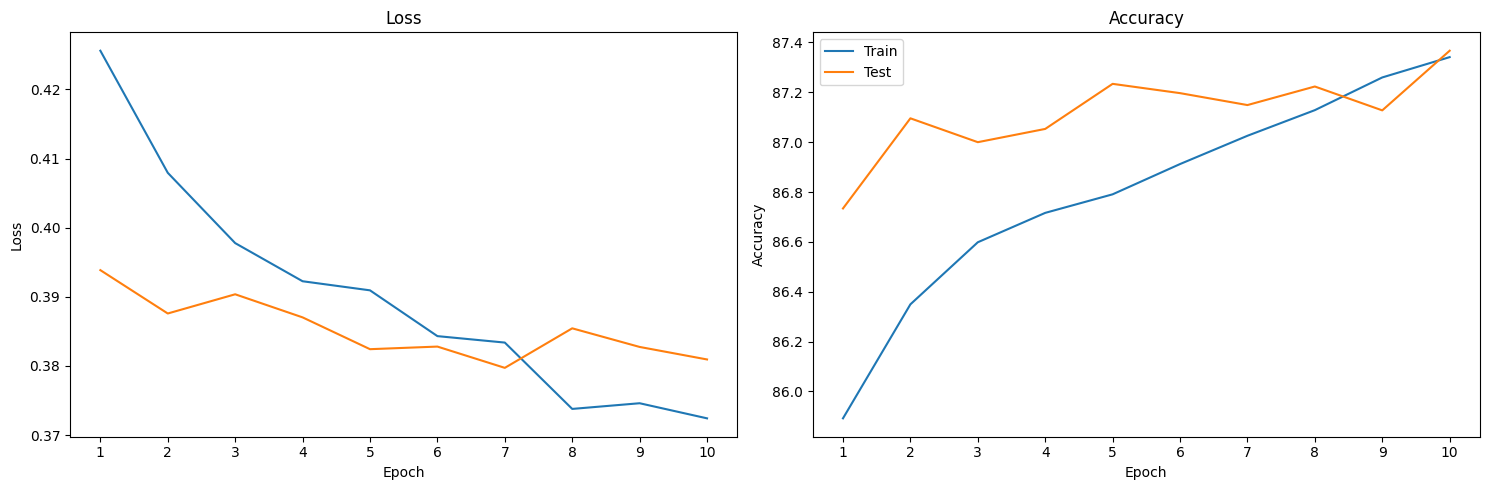

In [15]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)

results = train_model(model, 10, optimizer, train_loader, test_loader)

In [12]:
import torch
import torch.nn as nn

class ConvNN(nn.Module):
    def __init__(self, num_classes):
        super(ConvNN, self).__init__()

        self.network = nn.Sequential(
            # --- Convolution layers ---
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),  # (1,28,28) -> (32,28,28)
            nn.ReLU(),
            nn.MaxPool2d(2),  # (32,14,14)

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # (32,14,14) -> (64,14,14)
            nn.ReLU(),
            nn.MaxPool2d(2),  # (64,7,7)

            nn.Flatten(),

            # --- Fully Connected layers ---
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(0.20),

            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.20),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.20),

            nn.Linear(64, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.15),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.network(x)


Train Loss = 0.450 | Train Acc = 85.28% | Test Loss = 0.373 | Test Acc = 87.31% : 100%|██████████| 10/10 [05:36<00:00, 33.68s/it]


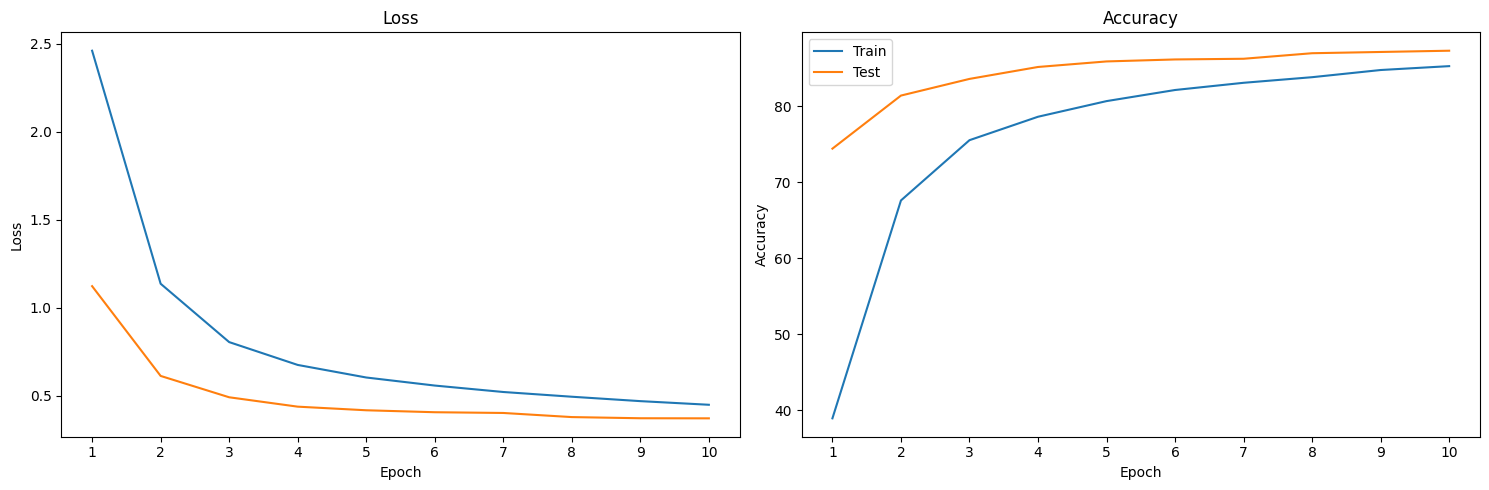

In [14]:
model = ConvNN(num_classes=len(classes)).to(device)

optimizer = optim.SGD(model.parameters(), lr=0.01)

results = train_model(model, 10, optimizer, train_loader, test_loader)